In [1]:
# Import useful libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy import special
from scipy.integrate import solve_ivp



# Chemical reaction
Consider the chemical reaction 

$$
A + B \rightleftharpoons C \, ,
$$

where $A$ and $B$ are two molecules that react to form the molecule $C$.
The forward rate at which an individual atom $A$ combines with an atom $B$ to form an atom $C$ is denoted by $r_F$.
While the backward reaction occurs at rate $r_B$.

However, in a system with $n_A(t)$, $n_B(t)$ and $n_C(t)$ atoms at time $t$, the probability of the forward reaction depends on the probability that an atom $A$ meets an atom $B$.
Then, the forward rate must take into account how many atoms $A$ and $B$ are present in the system with respect to the system size $\Omega$.
The reason for this is that $A$ and $B$ tend to react more readily when there is a significant concentration of $A$ and $B$.

Conversely, the breaking up of a $C$-molecule into its constituent atoms involves only the molecule $C$.
Then, the time evolution of $n_C(t)$ depends on the absolute number $n_C(t)$, independently on the system size.

Here, the system size is an extensive parameter that quantifies the relative magnitude of the reactants and of the products.
What precisely that parameter is will depend upon the problem at hand.
It could be either a capacitance (in electrical applications) or a volume or the number of individuals in a population. 

We conclude that, given $n_A(t)$ atoms at time $t$, the system evolves to

$$
n_A(t+\Delta t)  =  n_A(t) + r_B \, \Delta t n_C(t) - r_F \frac{n_B(t)}{\Omega} \Delta t \, n_A(t) \, .
$$

In other words, $n_A$ increases proportionally to $n_C$ multiplied by the rate $r_B$, and decreases proportionally to  $n_A$  multiplied by the rate $r_F \frac{n_B}{\Omega}$.   
 
Moving $n_A(t)$ to the LHS, dividing by $\Delta t$ and taking the limit $\Delta t \rightarrow 0$ yields the chemical equation

$$
\dot{n}_A = r_B\, n_{C} - r_F \frac{n_B}{\Omega}\, n_A n_B \, .
$$

This equation is called reaction rate as it expresses how the rate of $A$ atoms evolves with time.
The rate of $n_A$ is given as the difference between the forward rate $r_F \frac{n_B}{\Omega}\, n_A n_B$ and the backward rate $r_B\, n_{C}$.

Likewise, one gets the equations for $n_B$ and $n_C$:

\begin{eqnarray}
\dot{n}_A &=& r_B\, n_{C} - r_F\frac{n_B}{\Omega}\, n_A \cr
\dot{n}_B &=& r_B\, n_{C} - r_F\frac{n_A}{\Omega}\, n_B \cr
\dot{n}_{C} &=& r_F\, \frac{n_A n_B}{\Omega} - r_B\, n_{C}  \, .
\end{eqnarray}

To reduce the dimensionality, we consider the case where $n_A(t)=n_B(t)=n(t)$, i.e. the number of atoms $A$ is equal to the number of atoms $B$.
It follows, that the number $N = n(t) + n_C(t)$ is constant over the time, and the number of $C$ atoms is $n_C(t) = N - n(t)$. 

Here, we can use the parameter $N$ as system size: $\Omega = N$.
However, it should not be confused with the total number of atoms $N+n(t)$ which changes with time.

The system of equations is replaced by:

\begin{eqnarray}
\dot{n} &=& r_B\, (N - n) - r_F\, \frac{n^2}{N} \cr
\dot{n} &=& r_B\, (N - n) - r_F\,\, \frac{n^2}{N} \cr
N - \dot{n} &=& r_F\, \frac{n^2}{N} - r_B\, (N - n)  \, .
\end{eqnarray}

In the last equation, we used $\dot{n_c} = \frac{\mathrm{d}n_c}{\mathrm{d} t} = \frac{\mathrm{d}(N - n)}{\mathrm{d} t}  = N -\frac{\mathrm{d} n}{\mathrm{d} t}$.

Rearranging the last equation, we obtain

\begin{eqnarray}
\dot{n} &=& N - r_B\, (N - n) - r_F\, \frac{n^2}{N} \, .
\end{eqnarray}

In conclusion, the system is fully determined by the variable $n(t)$ and the dynamics is governed by the equation

$$
\dot{n} = r_B\, (N - n) - r_F\, \frac{n^2}{N} \, , 
$$

where $\dot{n}$ is the rate of $n$, $r_B\, (N - n)$ is the backward rate, and $r_F\, \frac{n^2}{N}$ is the forward rate.

Dividing by $N$, we obtain the equivalent equation for the macroscopic part derived by Linear Noise Approximation:

$$
\dot{\varphi} = r_B\, (1 - \varphi) - r_F\, \varphi^2 \, .
$$

### Gillespie algorithm
1. We estimate the total rate at time $t$:

$$
r(t) = r_B(N - n(t)) + r_F \frac{n(t)^2}{N} \, . 
$$

2. At time $t$, we draw the length of the next step $\tau$ from the distribution

$$
r(t)  \exp\left(-r(t)\tau\right) \mathrm{d}\tau \, ,
$$

that describes the probability to change the system state in the time interval $[t + \tau, t + \tau +\mathrm{d}\tau]$, with $\mathrm{d}\tau$ infinitesimal time step.

Calculating the CDF and by exploiting the probability integral transform theorem, the time interval $\tau$ can be calculated as

$$
\tau = - \frac{\log(u_1)}{r(t)} \, ,
$$
with $u_1\in \mathcal{U}(0,1)$ random number from a uniform distribution.

3. The probability that the forward reaction occurs is $P_F(t)= r_F \frac{n(t)^2}{N} \frac{1}{r(t)}$, while the probability of the backward reaction is $P_B(t)= r_B(N - n(t)) \frac{1}{r(t)}$
4. We draw a second random number $u_2$ from a uniform distribution $\mathcal{U}(0,1)$
5. If $u_2<P_f$ the forward reaction occurs, otherwise the bacward reaction occurs.

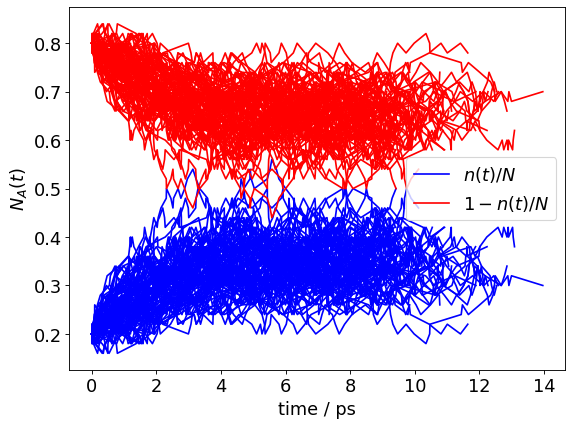

In [2]:
# Number of simulations
Nreps  = 1000

# Number of Gillispie time-steps (iterations)
Gsteps = 60  

# Array where to store the real timem for each replica
real_time = np.zeros((Gsteps, Nreps))

# System size
N   =  50

# Initial populations: n_a = n_b = n, then n_c = N - n
n0  =   10
n       =  np.zeros((Gsteps, Nreps))
n[0,:]  =  n0 * np.ones(Nreps)

# Rates of individual reactions (constants)
rF = 0.5
rB = 0.1


for t in range(Gsteps-1):
    # Calculate total rate for each replica
    r  = rF * n[t,:] * n[t,:] / N + rB * (N - n[t,:])
    
    # Calculate probability of the forward reaction
    Pf  = rF * n[t,:] * n[t,:] / N / r
    
    # Draw first random number (one for each replica)
    u1 = np.random.uniform(0, 1, (Nreps))
    
    # Draw time interval tau (of each replica) and update the real time (of each replica)
    tau = - np.log(u1) / r
    real_time[t+1,:] = real_time[t,:] + tau

    # Draw second random number (one for each replica)
    u2 = np.random.uniform(0, 1, (Nreps))
    
    # Select the either the forward or the backward reaction
    for rep in range(Nreps):
        # Forward reaction
        if  u2[rep] <= Pf[rep]:
            n[t+1,rep]  = n[t,rep] - 1
            
        # Backward reaction
        elif u2[rep] > Pf[rep]:
            n[t+1,rep]  = n[t,rep] + 1

##Figure

plt.figure(figsize=(8, 6), dpi=80)
font = {'size'   : 16}
plt.rc('font', **font)

plt.plot(real_time[:,0], n[:,0]/N,  color='b', label = r'$n(t) / N$')
plt.plot(real_time[:,0], 1-n[:,0]/N,  color='r', label = r'$1 - n(t) / N$')

plt.plot(real_time[:,0:-1:10], n[:,0:-1:10]/N,  color='b')
plt.plot(real_time[:,0:-1:10], 1-n[:,0:-1:10]/N,  color='r')

#lt.ylim((0,1))
plt.legend()

#plt.legend()
plt.xlabel('time / ps')
plt.ylabel(r'$N_A(t)$');

The trajectories stored in the variable **n** have different time lengths stored in the variable **real_time**. Addittionally, they are discretized with different timesteps **tau**.
To estimate the average trajectory and the variance of the fluctuations, we create an array **tvalues** of time values equally spaced.
timestep

The average value of **n** at time **tvalues[i+1]** is obtained from all the points (i.e. from all simulations) that fall in the interval **[tvalues[i], tvalues[i+1]]**.

<img src="avg.png" alt="Drawing" style="width: 500px;"/>

In [3]:
# Find minimum max path length
maxstep = np.max(real_time)

# Number of timesteps in the new time-discretization
Nsteps = 30

# Array of t values, use the maximum time as limit
tvalues = np.linspace(0, maxstep, Nsteps)

# Grid for histogram
nmin     = 0
nmax     = N
nvalues  = 1 + nmax - nmin
nedges   = np.linspace(nmin, nmax, nvalues, dtype = int) 
ncenters = nedges + 0.5
ncenters = np.delete(ncenters,-1)
nvalues  = len(ncenters)

# Array for histogram
H = np.zeros((Nsteps, nvalues))

# Histogram of the first step
h = np.histogram(n[0,:].T, bins=nedges, density=True)
H[0,:]   = h[0]

    
# Array for mean trajectory (from Gillespie simulations)
mean_n = np.zeros(Nsteps)
mean_n[0] = n0

# Array for average fluctuations
var_f  = np.zeros(Nsteps)

for i in range(Nsteps-1):
    ti   =  tvalues[i]      # t_i
    ti1  =  tvalues[i+1]    # t_{i+1}
    tcount = 0
    
    #values that fall in [t_i, t_{i+1}]
    el_n = []
    for g in range(Gsteps):
        
        # Check if the considered real_time[g,:] falls in the interval [t_i, t_{i+1}]
        idx    =  ((ti <= real_time[g,:]) & (real_time[g,:] < ti1))    
        tcount =  tcount + np.sum(idx)
        mean_n[i+1] =  mean_n[i+1] + np.sum(n[g,idx])
        if n[g,idx].size > 0:
            el_n.append(np.array(n[g,idx]))
        
    mean_n[i+1] = mean_n[i+1] / tcount   
    var_f[i+1]  = np.var(np.concatenate(el_n))    
    h           = np.histogram(np.concatenate(el_n), bins=nedges, density=True)
    H[i+1,:]    = h[0]
    


Macroscopic part derived by Linear Noise Approximation:

$$
\dot{\varphi} = r_B\, (1 - \varphi) - r_F\, \varphi^2 \, .
$$

Mean of the fluctuations:
$$
\frac{\partial \langle x\rangle}{\partial t} 
=
( - 2 r_F \varphi - b) \langle x\rangle
$$

Variance of the fluctuations:
$$
\frac{\partial \langle x^2\rangle}{\partial t} 
=
2 ( - 2 r_F \varphi - b) \langle x^2\rangle + \varphi^2 r_F + r_B - \varphi r_B
$$

In [4]:
def ODEs(t, z, rF, rB):
    phi, x1, x2  =  z
    dotphi  = - phi ** 2 * rF + rB * ( 1 - phi )
    dotx1   = ( - 2 * rF * phi - rB ) * x1
    dotx2   = 2 * ( - 2 * rF * phi - rB ) * x2 + phi ** 2 * rF + rB - phi * rB
    return [dotphi, dotx1, dotx2]

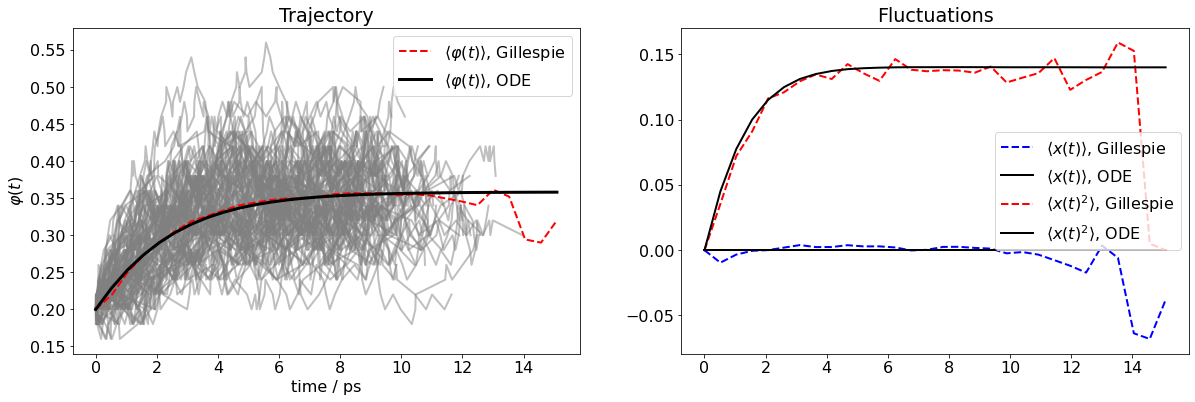

In [6]:
sol = solve_ivp(ODEs, [0, maxstep], [n0/N, 0, 0], args=(rF, rB), method='RK45', dense_output=True)
phi = sol.sol(tvalues)

avg_phi = phi[0].T
avg_x = phi[1].T
var_x = phi[2].T


fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20, 6))
ax1.plot(real_time[:,0:-1:10], n[:,0:-1:10]/N,  '-', color='grey', alpha=0.5, linewidth  =2)
ax1.plot(tvalues, mean_n/N, '--', color = 'red', label=r'$\langle \varphi(t) \rangle$, Gillespie', linewidth  =2)
ax1.plot(tvalues, avg_phi, 'k-', label=r'$\langle \varphi(t) \rangle$, ODE', linewidth  =3)
ax1.legend()
ax1.set_title('Trajectories')
ax1.set_xlabel('time / ps')
ax1.set_ylabel(r'$\varphi(t)$')
ax1.set_title('Trajectory')

ax2.plot(tvalues, mean_n/N - avg_phi, 'b--', label=r'$\langle x(t) \rangle$, Gillespie', linewidth  =2)
ax2.plot(tvalues, avg_x, 'k-',   label=r'$\langle x(t) \rangle$, ODE', linewidth  =2)
ax2.plot(tvalues, var_f/N,  'r--', label=r'$\langle x(t)^2 \rangle$, Gillespie', linewidth  =2)
ax2.plot(tvalues, var_x,  'k-', label=r'$\langle x(t)^2 \rangle$, ODE', linewidth  =2)
ax2.legend()
ax2.set_title('Fluctuations');

$$
\Pi(x,t) = \frac{1}{\sqrt{2\pi\, \langle x(t)^2 \rangle}} 
\exp\left(
-\frac{1}{2}
\frac{
\left(
x - \langle x(t) \rangle
\right)^2
}
{
\langle x(t)^2 \rangle
}
\right)
$$

$$
P(n,t) = \frac{1}{\sqrt{N}}\Pi\left(\frac{n - N \varphi(t)}{\sqrt{N}},t\right)
$$

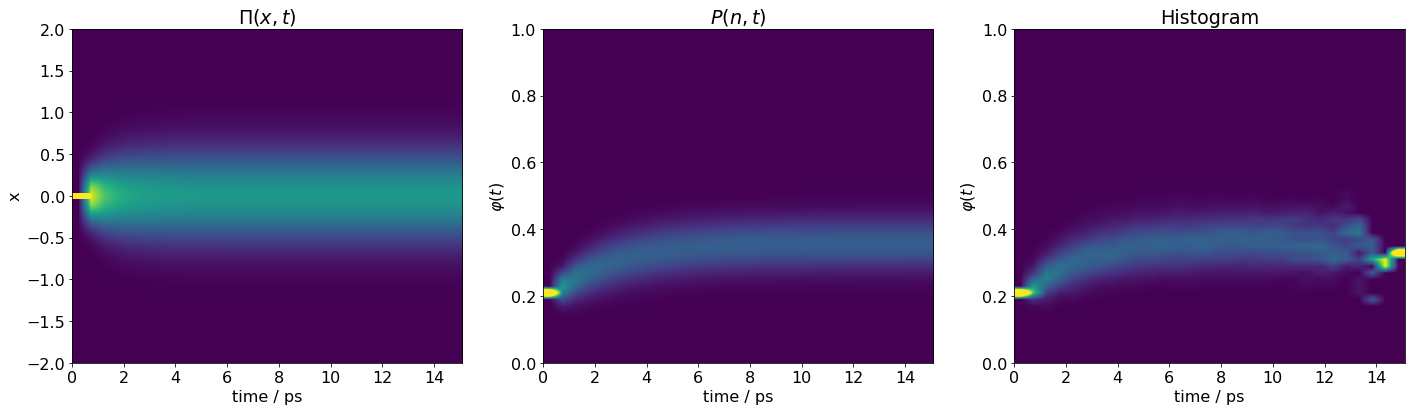

In [43]:
def solutionFP(x,t):
    return ( 2 * np.pi * var_x[t] ) ** - 0.5 * np.exp( - 0.5 * (x - avg_x[t]) ** 2 * var_x[t] ** - 1 )

# Grid for histogram
xmin     = -2
xmax     =  2
xvalues  = 100
xedges   = np.linspace(xmin, xmax, xvalues) 
dx       = xedges[1] - xedges[0]
xcenters = xedges + 0.5 * dx
xcenters = np.delete(xcenters,-1)
xvalues  = len(xcenters)


PI  = np.zeros((Nsteps, xvalues))
h   = np.histogram(0, bins=xedges, density=True)
PI[0,:]   = h[0]

P = np.zeros((Nsteps, nvalues))
h   = np.histogram(n0, bins=nedges, density=True)
P[0,:]   = h[0]

for t in range(1,Nsteps):
    PI[t,:]   = solutionFP(xcenters, t)
    P[t,:]    = solutionFP( (ncenters - N * avg_phi[t]) / np.sqrt(N), t) /  np.sqrt(N)
    
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

extent = 0, maxstep, xmin, xmax
ax1.imshow(PI.T, interpolation='bilinear', extent = extent, aspect='auto', origin='lower',vmin=0, vmax=2);
ax1.set_xlabel('time / ps')
ax1.set_ylabel('x')
ax1.set_title(r'$\Pi(x,t)$')

extent = 0, maxstep, nmin/N, nmax/N
ax2.imshow(P.T, interpolation='bilinear', extent = extent, aspect='auto', origin='lower',vmin=0, vmax=0.5);
ax2.set_xlabel('time / ps')
ax2.set_ylabel(r'$\varphi(t)$')
ax2.set_title(r'$P(n,t)$')

extent = 0, maxstep, nmin/N, nmax/N

ax3.imshow(H.T, interpolation='bilinear', extent = extent, aspect='auto', origin='lower',vmin=0, vmax=0.5);
ax3.set_xlabel('time / ps')
ax3.set_ylabel(r'$\varphi(t)$')
ax3.set_title('Histogram')

fig.tight_layout()